In [1]:
import warnings
import logging

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.CRITICAL)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import tensorflow as tf
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from chronos import ChronosPipeline

import yaml
from abc import ABC, abstractmethod
from tqdm import tqdm
import optuna
import cmdstanpy

In [5]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')
warnings.filterwarnings('ignore', category=FutureWarning, module='tensorflow')
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='statsmodels')

logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [6]:
data_path = "data/combined_data.csv"

data = pd.read_csv(data_path)
data['Dia'] = pd.to_datetime(data['Dia'])
data.sort_values(['Nombre', 'Producto', 'Dia'], inplace=True)

## Clase abstracta

In [7]:
base_cols = ['PVP']
meteo_cols = ['dir', 'prec', 'presMax', 'presMin', 'racha', 'sol', 'tmax', 'tmed', 'tmin', 'velmedia']
ts_cols = ['t_diff_1', 't_diff_2', 't_diff_3', 't_diff_4', 't_diff_5', 't_diff_6', 't_diff_7', 't_diff_30', 't_diff_365']
price_cols = ['count_comp', 'mean_comp', 'min_comp', 'max_comp']
traffic_cols = ['month_traffic_mean', 'weekly_traffic_mean']
population_cols = ['population_00-19', 'population_20-29', 'population_30-49', 'population_50-64', 'population_65-99', 'population_total']
vehicle_cols = ['n_veh_car', 'n_veh_motorcycle', 'n_veh_other', 'n_veh_truck']
cat_cols = ["Producto"]

exogenous_vars = base_cols + ts_cols + meteo_cols + price_cols + traffic_cols
general_ex_vars = base_cols + ts_cols + meteo_cols + price_cols + traffic_cols + population_cols + vehicle_cols + cat_cols

n_splits = 12
test_size = 30

CONFIG_DEFAULT = {
    "exogenous_vars": exogenous_vars, 
    "general_ex_vars": general_ex_vars,
    "cv_params": {
        "n_splits": n_splits, 
        "test_size": test_size,
    },
}

In [8]:
class Scorer(ABC):
    
    def __init__(self, config=CONFIG_DEFAULT, **model_params):
        self.exogenous_vars = config["exogenous_vars"]
        self.features_length = len(self.exogenous_vars)
        self.cv_params = config["cv_params"]
        self.model_params = model_params

    @abstractmethod
    def create_model(self):
        pass
    
    def process_data(self, df, scale=True):
        for i in range(1, 8):
            df[f't_diff_{i}'] = df['VentasN'].diff(periods=i)
        df['t_diff_30'] = df['VentasN'].diff(periods=30)
        df['t_diff_365'] = df['VentasN'].diff(periods=365)
        df = df.dropna(axis=1, how="all")
        df = df.fillna(method='ffill')
        df = df.dropna()

        self.time_series = df["Dia"].values
        
        if scale:
            scaler = MinMaxScaler()
            X = scaler.fit_transform(df[self.exogenous_vars])
        else:
            X = df[self.exogenous_vars].values
        y = df['VentasN'].values

        X, y = self.arrage_data(X, y)
        return X, y

    def arrage_data(self, X, y):
        return X, y

    def cross_validate_model(self, model, X, y):
        cv = TimeSeriesSplit(**self.cv_params)
        scores = cross_validate(model, X, y, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'], cv=cv)
        rmse_list = -scores['test_neg_root_mean_squared_error']
        mape_list = -scores['test_neg_mean_absolute_percentage_error']
        return rmse_list, mape_list

    def run(self, data, verbose=True, get_models=False, show_progress=True):
        results = []
        models = []
        total = len(data['Nombre'].unique()) * len(data['Producto'].unique())
        months = ["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan"]
        
        progress_bar = tqdm(total=total, desc="Running") if show_progress else None

        for estacion in data['Nombre'].unique():
            for producto in data[data['Nombre'] == estacion]['Producto'].unique():
                df = data[(data['Nombre'] == estacion) & (data['Producto'] == producto)].copy()
                X, y = self.process_data(df)
                model = self.create_model()
                rmse_list, mape_list = self.cross_validate_model(model, X, y)

                estacion_results = [
                    {
                        'Model': self.model_name,
                        'Estación': estacion, 
                        'Producto': producto,
                        'Month': months[i], 
                        'RMSE': rmse_list[i], 
                        'MAPE': mape_list[i],
                    }
                    for i in range(len(rmse_list))
                ]

                results = results + estacion_results
                if get_models:
                    model = self.create_model()
                    model.fit(X, y)
                    models.append(model)
                
                if show_progress:
                    progress_bar.update(1)
        
        if show_progress:
            progress_bar.close()
        
        results_df = pd.DataFrame(results)

        if verbose:
            print(f"Mean RMSE: {round(results_df['RMSE'].mean(), 4)}")
            print(f"Median MAPE: {round(results_df['MAPE'].median() * 100, 2)}%")

        return results_df, models


In [9]:
class LSTMModel(BaseEstimator, RegressorMixin):
    def __init__(self, lstm_layers=[8, 8], dense_layers=[8, 4], epochs=2, batch_size=32, sequence_length=5):
        self.lstm_layers = lstm_layers
        self.dense_layers = dense_layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        
    def build_model(self, lstm_layers, dense_layers, input_shape):
        model = Sequential()
        for i, units in enumerate(lstm_layers):
            if i == 0:
                model.add(LSTM(units, return_sequences=(i < len(lstm_layers) - 1), input_shape=input_shape))
            else:
                model.add(LSTM(units, return_sequences=(i < len(lstm_layers) - 1)))
        for units in dense_layers:
            model.add(Dense(units, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.lstm_model = self.build_model(self.lstm_layers, self.dense_layers, X.shape[1:])
        self.lstm_model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=False)

    def predict(self, X):
        return self.lstm_model.predict(X, verbose=False).flatten()

    def get_params(self, deep=True):
        return {
            "lstm_layers": self.lstm_layers,
            "dense_layers": self.dense_layers,
            "epochs": self.epochs,
            "batch_size": self.batch_size,
            "sequence_length": self.sequence_length,
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

class SARIMAXModel(BaseEstimator, RegressorMixin):
    def __init__(self, order, seasonal_order=(0, 0, 0, 0)):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X, y):
        self.sarimax_model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.sarimax_model = self.sarimax_model.fit(method="lbfgs", maxiter=50)

    def predict(self, X):
        return self.sarimax_model.forecast(steps=len(X), exog=X)

    def get_params(self, deep=True):
        return {"order": self.order, "seasonal_order": self.seasonal_order}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

class ProphetModel(BaseEstimator, RegressorMixin):
    def __init__(self, time_series, **model_params):
        self.time_series = time_series
        self.model_params = model_params
        self.prophet_model = Prophet(**self.model_params)
    
    def fit(self, X, y):
        df = pd.DataFrame(X).copy()
        df['y'] = y
        df['ds'] = self.time_series[:len(df)]
        self.prophet_model.fit(df)
    
    def predict(self, X):
        future = self.prophet_model.make_future_dataframe(periods=len(X))
        forecast = self.prophet_model.predict(future)
        y_pred = forecast['yhat'][-len(X):].values
        
        return y_pred
    
    def get_params(self, deep=True):
        return {"time_series": self.time_series, **self.model_params}

    def set_params(self, time_series, **params):
        self.time_series = time_series
        self.model_params = params
        return self


class ChronosBaseModel(BaseEstimator, RegressorMixin):
    def __init__(self, chronos_pipeline):
        self.chronos_pipeline = chronos_pipeline
    
    def fit(self, X, y):
        self.context = torch.tensor(y)
        return self
    
    def predict(self, X):
        
        y_pred = self.chronos_pipeline.predict(
            context=self.context,
            prediction_length=X.shape[0],
            num_samples=1,
        )
        
        return np.array(y_pred.squeeze())
    
    def get_params(self, deep=True):
        return {"chronos_pipeline": self.chronos_pipeline}

    def set_params(self, chronos_pipeline):
        self.chronos_pipeline = chronos_pipeline
        return self
    
class ChronosModel(BaseEstimator, RegressorMixin):
    def __init__(self, chronos_pipeline, t_col, base_model):
        self.chronos_pipeline = chronos_pipeline
        self.t_col = t_col
        self.base_model = base_model

    def _embed(self, X):
        self.chronos_pipeline.tokenizer.config.context_length = len(X)
        y_context = torch.tensor(X[:, self.t_col])
        y_embeddings, _ = self.chronos_pipeline.embed(y_context)
        y_embeddings = y_embeddings[0][:-1].to(torch.float32).numpy()
        X_embedding = np.concatenate((X, y_embeddings), axis=1)
        return X_embedding
    
    def fit(self, X, y):
        self.context = X.copy()
        X_embedding = self._embed(self.context)
        self.base_model = self.base_model.fit(X_embedding, y)
        return self
    
    def predict(self, X):
        X_context = np.concatenate((self.context, X), axis=0) 
        X_embedding = self._embed(X_context)        
        y_pred = self.base_model.predict(X_embedding[-len(X):])
        return y_pred
    
    def get_params(self, deep=True):
        return {
            "chronos_pipeline": self.chronos_pipeline,
            "t_col": self.t_col,
            "base_model": self.base_model,
        }

    def set_params(self, chronos_pipeline, t_col, base_model):
        self.chronos_pipeline = chronos_pipeline
        self.t_col = t_col
        self.base_model = base_model
        return self

In [10]:
class LinearRegressionScorer(Scorer):
    def create_model(self):
        self.model_name = "linear_regression"
        return LinearRegression(**self.model_params)

class LassoScorer(Scorer):
    def create_model(self):
        self.model_name = "lasso"
        return Lasso(**self.model_params)

class XGBoostScorer(Scorer):
    def create_model(self):
        self.model_name = "xgboost"
        return XGBRegressor(**self.model_params)

class CatBoostScorer(Scorer):
    def create_model(self):
        self.model_name = "catboost"
        return CatBoostRegressor(**self.model_params, verbose=False)
    
class RandomForestScorer(Scorer):
    def create_model(self):
        self.model_name = "random_forest"
        return RandomForestRegressor(**self.model_params)

class ProphetScorer(Scorer):
    def create_model(self):
        self.model_name = "prophet"
        return ProphetModel(self.time_series, **self.model_params)
    
class ChronosBaseScorer(Scorer):
    def create_model(self):
        self.model_name = "chronos_base"
        return ChronosBaseModel(**self.model_params)

class ChronosScorer(Scorer):
    def create_model(self):
        self.model_name = "chronos"
        return ChronosModel(**self.model_params)

class DummyMeanScorer(Scorer):
    def create_model(self):
        self.model_name = "dummy_mean"
        return DummyRegressor(strategy="mean")

class DummyShiftScorer(Scorer):

    def create_model(self):
        self.model_name = f'dummy_shift_{self.model_params["shift"]}'
    
    def cross_validate_model(self, model, X, y):
        shift_value = self.model_params["shift"]

        y_pred = np.roll(y, shift_value)
        y_pred[:shift_value] = y[:shift_value]

        rmse = mean_squared_error(y, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y, y_pred)

        return [rmse], [mape]

class LSTMScorer(Scorer):
    def arrage_data(self, X, y):
        sequence_length = 5

        X_seq, y_seq = [], []
        for i in range(len(X) - sequence_length + 1):
            X_seq.append(X[i:i + sequence_length])
            y_seq.append(y[i + sequence_length - 1])
        return np.stack(X_seq), np.stack(y_seq)
    
    def create_model(self):
        self.model_name = "lstm"
        return LSTMModel(**self.model_params)

class SARIMAXScorer(Scorer):
    def create_model(self):
        self.model_name = "sarimax"
        return SARIMAXModel(**self.model_params)

    def process_data(self, df):
        ts_cols = [f't_diff_{i}' for i in range(1, 8)] + ["t_diff_30", "t_diff_365"]
        selected_vars = [col for col in self.exogenous_vars if col not in ts_cols]

        df = df.dropna(axis=1, how="all")
        df = df.fillna(method='ffill')
        df = df.dropna()
        
        scaler = MinMaxScaler()
        X = scaler.fit_transform(df[selected_vars])
        y = df['VentasN'].values

        X, y = self.arrage_data(X, y)
        return X, y

## Resultados de los modelos

In [13]:
total_results = pd.read_csv("data/models_results.csv")

In [14]:
chronos_pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

chronos_base_scorer = ChronosScorer(
    chronos_pipeline=chronos_pipeline, 
    t_col=CONFIG_DEFAULT["exogenous_vars"].index("t_diff_1"), 
    base_model=LinearRegression(), 
)

results_chronos, chronos_base_models = chronos_base_scorer.run(data)
total_results = pd.concat([total_results, results_chronos])

# Mean RMSE: 0.0461
# Median MAPE: 11.35%

Running: 100%|██████████| 24/24 [17:31<00:00, 43.83s/it]

Mean RMSE: 0.0461
Median MAPE: 11.35%


In [15]:
chronos_pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

chronos_base_scorer = ChronosBaseScorer(chronos_pipeline=chronos_pipeline)
results_chronos_base, chronos_base_models = chronos_base_scorer.run(data)
total_results = pd.concat([total_results, results_chronos_base])

# Mean RMSE: 0.0883
# Median MAPE: 20.05%


Running: 100%|██████████| 24/24 [8:24:45<00:00, 1261.91s/it]   

Mean RMSE: 0.0883
Median MAPE: 20.05%


In [12]:
lasso_scorer = LassoScorer(alpha=0.001)
results_lasso, lasso_models = lasso_scorer.run(data, get_models=True)
total_results = pd.concat([total_results, results_lasso])

# Mean RMSE: 0.0356
# Median MAPE: 8.5%

Running: 100%|██████████| 24/24 [00:00<00:00, 46.29it/s]

Mean RMSE: 0.0356
Median MAPE: 8.5%


In [ ]:
prophet_scorer = ProphetScorer()
results_prophet, prophet_models = prophet_scorer.run(data)
total_results = pd.concat([total_results, results_prophet])

# Mean RMSE: 0.0768
# Median MAPE: 17.69%

In [14]:
sarimax_scorer = SARIMAXScorer(order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
results_sarimax, models = sarimax_scorer.run(data)
total_results = pd.concat([total_results, results_sarimax])

# Mean RMSE: 0.074
# Median MAPE: 16.65%

Running: 100%|██████████| 24/24 [27:21<00:00, 68.39s/it]

Mean RMSE: 0.074
Median MAPE: 16.65%


In [21]:
rf_scorer = RandomForestScorer(max_depth=5, n_estimators=100)
results_rf, models = rf_scorer.run(data)
total_results = pd.concat([total_results, results_rf])

# Mean RMSE: 0.0374
# Median MAPE: 8.89%

Running: 100%|██████████| 24/24 [02:17<00:00,  5.73s/it]

Mean RMSE: 0.0374
Median MAPE: 8.89%


In [ ]:
lstm_scorer = LSTMScorer(lstm_layers=[64, 32], dense_layers=[32, 16], epochs=25, batch_size=32, sequence_length=10)
results_lstm, models = lstm_scorer.run(data)
total_results = pd.concat([total_results, results_lstm])

# Mean RMSE: 0.0365
# Median MAPE: 8.54%

In [23]:
dummy_mean_model = DummyMeanScorer()
results_dummy, models = dummy_mean_model.run(data)
total_results = pd.concat([total_results, results_dummy])

# Mean RMSE: 0.0925
# Median MAPE: 22.87%

Running: 100%|██████████| 24/24 [00:00<00:00, 73.09it/s]

Mean RMSE: 0.0925
Median MAPE: 22.87%


In [18]:
dummy_shift_model = DummyShiftScorer(shift=1)
results_df, models = dummy_shift_model.run(data)

# Mean RMSE: 0.1226
# Median MAPE: 47.0%

Running: 100%|██████████| 24/24 [00:00<00:00, 63.10it/s]

Mean RMSE: 0.1226
Median MAPE: 47.0%


In [19]:
dummy_shift_model = DummyShiftScorer(shift=7)
results_df, models = dummy_shift_model.run(data)

# Mean RMSE: 0.099
# Median MAPE: 34.96%

Running: 100%|██████████| 24/24 [00:00<00:00, 58.57it/s]


Mean RMSE: 0.099
Median MAPE: 34.96%


In [170]:
xgb_model  = XGBoostScorer(n_estimators=500, max_depth=5, learning_rate=0.05, random_state=0)
results_xgb, xgb_models = xgb_model.run(data, get_models=True)
total_results = pd.concat([total_results, results_xgb])

# Mean RMSE: 0.0319
# Median MAPE: 7.56%

Running: 100%|██████████| 24/24 [02:08<00:00,  5.37s/it]

Mean RMSE: 0.0319
Median MAPE: 7.56%


In [171]:
catb_model = CatBoostScorer(iterations=500, learning_rate=0.05, depth=5)
results_catb, catb_models = catb_model.run(data, get_models=True)
total_results = pd.concat([total_results, results_catb])

# Mean RMSE: 0.0305
# Median MAPE: 7.51%

Running: 100%|██████████| 24/24 [14:05<00:00, 35.25s/it]  

Mean RMSE: 0.0305
Median MAPE: 7.51%


In [30]:
total_results.to_csv("data/models_results.csv", index=False)

## Modelo general

In [45]:
class GeneralModelScorer(Scorer):

    def __init__(self, base_model, config=CONFIG_DEFAULT):
        self.exogenous_vars = config["general_ex_vars"]
        self.features_length = len(self.exogenous_vars)
        self.cv_params = config["cv_params"].copy()
        self.cv_params["test_size"] = self.cv_params["test_size"] * 24
        self.base_model = base_model
    
    def create_model(self):
        return self.base_model

    def run(self, data, verbose=True, only_scores=False, show_progress=True):
        existing_data = False

        for estacion in data['Nombre'].unique():
            for producto in data[data['Nombre'] == estacion]['Producto'].unique():
                
                df = data[(data['Nombre'] == estacion) & (data['Producto'] == producto)].copy()
                df["Producto"] = df["Producto"].apply(lambda p: int(p=="95"))
                X, y = self.process_data(df, scale=False)

                if not existing_data:
                    X_all = X.copy()
                    y_all = y.copy()
                    time_all = self.time_series
                    existing_data = True
                else:
                    X_all = np.concatenate((X_all, X))
                    y_all = np.concatenate((y_all, y))
                    time_all = np.concatenate((time_all, self.time_series))
        
        X_all = X_all[np.argsort(time_all)].copy()
        y_all = y_all[np.argsort(time_all)].copy()
                    
        model = self.create_model()

        rmse_list, mape_list = self.cross_validate_model(model, X_all, y_all)

        models = [model.fit(X_all, y_all)]
        results = {
            'Model': "general_model",
            'Estación': "", 
            'Producto': "",
            'Month': "", 
            'RMSE': np.mean(rmse_list), 
            'MAPE': np.median(mape_list),
        }

        if verbose:
            print(f"Mean RMSE: {round(np.mean(rmse_list), 4)}")
            print(f"Median MAPE: {round(np.median(mape_list) * 100, 2)}%")

        if only_scores:
            return results, models

        return results, models

In [68]:
gm_base_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=5, verbose=False)
gm_scorer = GeneralModelScorer(gm_base_model)
results_gm, gm_models = gm_scorer.run(data, only_scores=True)
total_results = pd.concat([total_results, pd.DataFrame([results_gm])]).reset_index(drop=True)

Mean RMSE: 0.0389
Median MAPE: 10.29%


In [69]:
total_results.to_csv("data/models_results.csv", index=False)

## Análisis de los resultados

In [73]:
total_results = pd.read_csv("data/models_results.csv")
agg_results = total_results.groupby("Model").agg({"RMSE": "mean", "MAPE": "median"}).reset_index()

In [74]:
agg_results

,Model,RMSE,MAPE
0,catboost,0.030536,0.075099
1,chronos,0.046064,0.113544
2,dummy_mean,0.092497,0.228697
3,general_model,0.038922,0.102898
4,lasso,0.035625,0.085041
5,lstm,0.036508,0.085362
6,prophet,0.076810,0.176917
7,random_forest,0.037391,0.088937
8,sarimax,0.074032,0.166521
9,xgboost,0.031950,0.075602


In [156]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
months_results = total_results.dropna().copy()
months_results["Month_index"] = months_results["Month"].apply(lambda x: months.index(x))
months_results = months_results.sort_values(by="Month_index")
months_results = months_results.groupby(["Model", "Month", "Month_index"], sort=False, as_index=False)[["RMSE", "MAPE"]].agg({"RMSE": "mean", "MAPE": "median"})
months_results = months_results.sort_values(by=['Month_index', 'RMSE'])
months_results = months_results.groupby('Month', sort=False).head(3)

def format_output(group):
    top_1 = group.iloc[0]
    top_2 = group.iloc[1]
    top_3 = group.iloc[2]
    
    return pd.Series({
        'RMSE': top_1['RMSE'],
        'Top 1 Modelo': top_1['Model'],
        'Top 2 Modelo': top_2['Model'],
        'Top 3 Modelo': top_3['Model']
    })

months_results = months_results.groupby('Month', sort=False).apply(format_output).reset_index()
months_results["Top 1 Modelo"] = months_results["Top 1 Modelo"].map({"catboost": "CatBoost", "xgboost": "XGBoost", "lstm": "LSTM"})

In [157]:
months_results

,Month,RMSE,Top 1 Modelo,Top 2 Modelo,Top 3 Modelo
0,Jan,0.041033,CatBoost,xgboost,lstm
1,Feb,0.026705,CatBoost,xgboost,lasso
2,Mar,0.031088,XGBoost,catboost,random_forest
3,Apr,0.024708,CatBoost,xgboost,random_forest
4,May,0.023393,CatBoost,xgboost,random_forest
5,Jun,0.022733,CatBoost,xgboost,lasso
6,Jul,0.036395,CatBoost,lstm,xgboost
7,Aug,0.043350,CatBoost,xgboost,lstm
8,Sep,0.023252,CatBoost,xgboost,lstm
9,Oct,0.025749,CatBoost,lstm,lasso


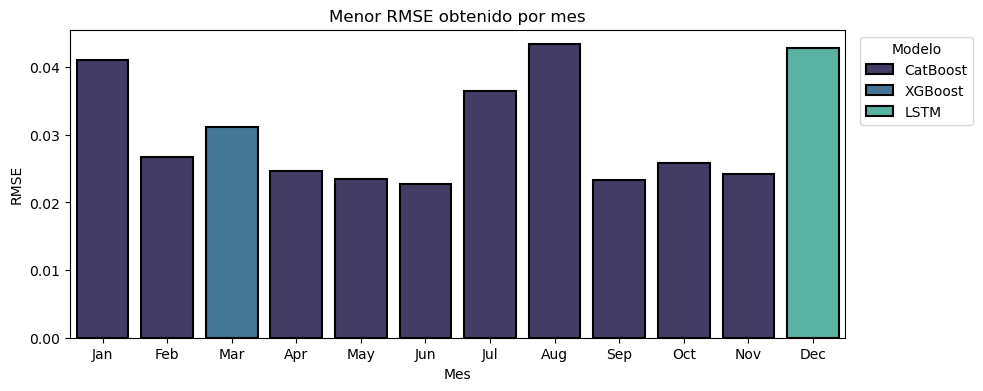

In [158]:
palette = sns.color_palette("mako", len(months_results['Top 1 Modelo'].unique()))
plt.figure(figsize=(10, 4))
sns.barplot(data=months_results, x='Month', y='RMSE', hue='Top 1 Modelo', dodge=False, palette=palette, linewidth=1.5, edgecolor='black')

plt.xlabel('Mes')
plt.ylabel('RMSE')
plt.title('Menor RMSE obtenido por mes')
plt.legend(title='Modelo', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

## Interpretación de los modelos

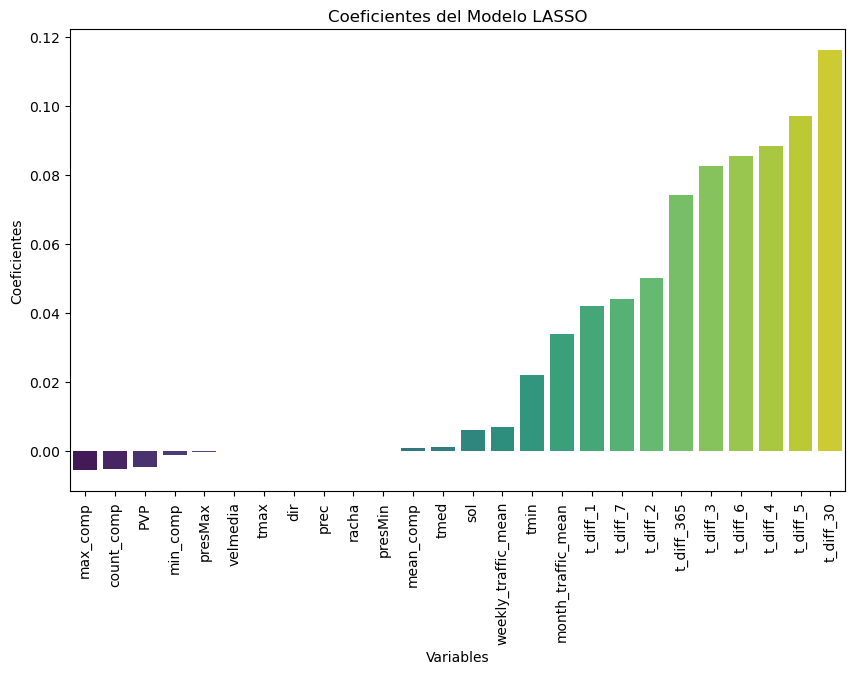

In [162]:
coefficients_array = np.array([model.coef_ for model in lasso_models])

linear_model_coef = pd.DataFrame({
    'variables': exogenous_vars,
    'coefficients': np.mean(coefficients_array, axis=0),
})

linear_model_coef = linear_model_coef.sort_values(by="coefficients")

plt.figure(figsize=(10, 6))
sns.barplot(x='variables', y='coefficients', data=linear_model_coef, palette='viridis')
plt.title('Coeficientes del Modelo LASSO')
plt.xlabel('Variables')
plt.ylabel('Coeficientes')
plt.xticks(rotation=90)
plt.show()

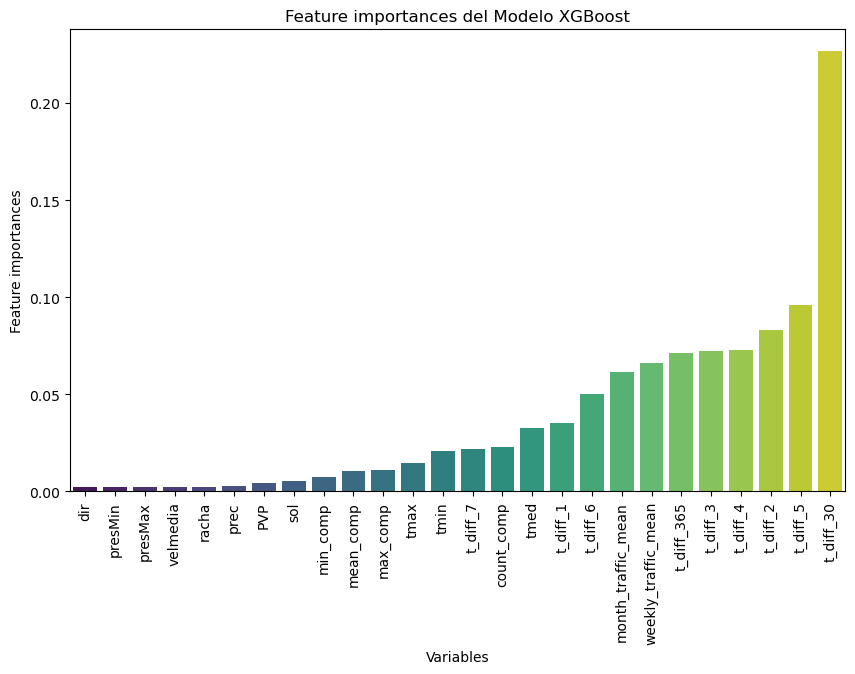

In [173]:
fimportances_array = np.array([model.feature_importances_ for model in xgb_models])

xgb_model_coef = pd.DataFrame({
    'variables': exogenous_vars,
    'coefficients': np.mean(fimportances_array, axis=0),
})

xgb_model_coef = xgb_model_coef.sort_values(by="coefficients")

plt.figure(figsize=(10, 6))
sns.barplot(x='variables', y='coefficients', data=xgb_model_coef, palette='viridis')
plt.title('Feature importances del Modelo XGBoost')
plt.xlabel('Variables')
plt.ylabel('Feature importances')
plt.xticks(rotation=90)
plt.show()

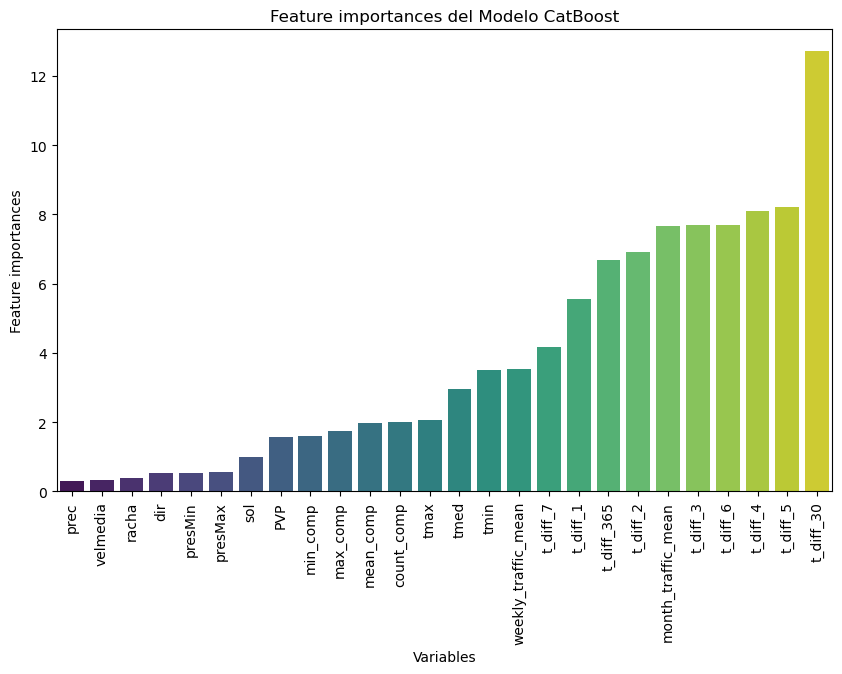

In [174]:
fimportances_array = np.array([model.feature_importances_ for model in catb_models])

catb_model_coef = pd.DataFrame({
    'variables': exogenous_vars,
    'coefficients': np.mean(fimportances_array, axis=0),
})

catb_model_coef = catb_model_coef.sort_values(by="coefficients")

plt.figure(figsize=(10, 6))
sns.barplot(x='variables', y='coefficients', data=catb_model_coef, palette='viridis')
plt.title('Feature importances del Modelo CatBoost')
plt.xlabel('Variables')
plt.ylabel('Feature importances')
plt.xticks(rotation=90)
plt.show()

## Grid Search

In [181]:
def scorer_optimizer(model_scorer, params_dict, data, n_trials=10):

    def objective(trial):

        instance_params = {}

        for param in params_dict:
            if param["type"] == "int":
                instance_params[param["name"]] = trial.suggest_int(
                    param["name"], param["value"][0], param["value"][1]
                )
            elif param["type"] == "float":
                instance_params[param["name"]] = trial.suggest_float(
                    param["name"], param["value"][0], param["value"][1]
                )
            elif param["type"] == "set":
                instance_params[param["name"]] = trial.suggest_categorical(
                    param["name"], param["value"]
                )
        
        scorer = model_scorer(**instance_params)
        
        rmse = scorer.run(data, verbose=False, show_progress=False)[0]["RMSE"].mean()
        
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Best hyperparameters: ", study.best_params)
    print("Best accuracy: ", study.best_value)

    return study.best_params

with open("grid_search.yaml", 'r') as stream:
    model_params = yaml.safe_load(stream)


In [ ]:
lasso_best_params = scorer_optimizer(LassoScorer, model_params["lasso"], data, n_trials=100)

In [ ]:
xgboost_best_params = scorer_optimizer(XGBoostScorer, model_params["xgboost"], data, n_trials=10)

In [ ]:
catboost_best_params = scorer_optimizer(CatBoostScorer, model_params["catboost"], data, n_trials=10)

In [185]:
lasso_best_params = {'alpha': 0.00090813661190240582}
lasso_scorer = LassoScorer(**lasso_best_params)
results_lasso, _ = lasso_scorer.run(data)

Running: 100%|██████████| 24/24 [00:00<00:00, 24.20it/s]

Mean RMSE: 0.0354
Median MAPE: 8.39%


In [187]:
xgb_best_params = {'n_estimators': 817, 'learning_rate': 0.03375812715450361, 'max_depth': 5, 'min_child_weight': 6.953999813625597, 'subsample': 0.5006734727592597}
xgb_model  = XGBoostScorer(**xgb_best_params)
results_xgb, _ = xgb_model.run(data)

Running: 100%|██████████| 24/24 [29:03<00:00, 72.64s/it] 

Mean RMSE: 0.0299
Median MAPE: 7.21%


In [188]:
catb_best_params = {'learning_rate': 0.05066787591097517, 'depth': 4, 'l2_leaf_reg': 3.102140460753001, 'iterations': 547}
catb_model = CatBoostScorer(**catb_best_params)
results_catb, _ = catb_model.run(data)

Running: 100%|██████████| 24/24 [02:39<00:00,  6.65s/it]

Mean RMSE: 0.0302
Median MAPE: 7.17%
